 - 이상치 기반 EDA

# 패키지 임포트

In [90]:
import sys
import os

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# # 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 상위 디렉토리에서 모듈 임포트
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
       sys.path.append(nb_dir)
import ldcc_forecast_01_2

In [91]:
data_dir = '../data'

# 객체 생성

In [92]:
fcst = ldcc_forecast_01_2.ldccForecast()

====================forecast 객체 생성======================
forecast 객체 생성됐습니다.


# Amazon Forecast, Forecastquery, S3 에 연동

In [93]:
fcst.region_name = 'ap-northeast-2'
#region_name = ['서울': 'ap-northeast-2', '싱가포르': 'ap-southeast-1']


fcst.connect_aws()

======================forecast 연동=======================
forecast에 연동됐습니다.
('\xec\x97\xb0\xeb\x8f\x99\xeb\x90\x9c region:  ', 'ap-northeast-2')
()
====================forecastquery 연동====================
forecastquery에 연동됐습니다.
('\xec\x97\xb0\xeb\x8f\x99\xeb\x90\x9c region:  ', 'ap-northeast-2')
()
=========================s3 연동==========================
s3에 연동됐습니다.
()


# IAM 설정

In [94]:
fcst.iam_config()

========================Role 생성=========================
()
======================Role 이미 존재=======================
RoleName: ForecastRoleDemo
RoleArn: arn:aws:iam::461548484502:role/ForecastRoleDemo
()


# S3에서 데이터 읽어오기

### - targetTS 17-01-01 ~ 20-03-31 불러오기

In [95]:
fcst.readS3BucketName = 'ldcc-cafeteria-01-bucket-bellship'
fcst.readS3Key = 'target_ts/lnch_long_total_0408.csv'  

fcst.read_s3data()

tar_df = fcst.df
tar_df['timestamp'] = pd.to_datetime(tar_df['timestamp'])

====================s3데이터 읽기=====================
()
데이터 읽어온 S3 경로: ldcc-cafeteria-01-bucket-bellship/target_ts/lnch_long_total_0408.csv
()
==============읽어온 df의 head===============
   timestamp item_id  target_value
0 2017-01-01   중식_소계             0
1 2017-01-02   중식_소계           360
2 2017-01-03   중식_소계           376
3 2017-01-04   중식_소계           396
4 2017-01-05   중식_소계           367
()
===============읽어온 df의 tail==============
      timestamp item_id  target_value
1181 2020-03-27   중식_소계           148
1182 2020-03-28   중식_소계             0
1183 2020-03-29   중식_소계             0
1184 2020-03-30   중식_소계           350
1185 2020-03-31   중식_소계           302
()
===============읽어온 df의 shape=============
(1186, 3)
()
===============읽어온 df의 columns===========
Index([u'timestamp', u'item_id', u'target_value'], dtype='object')
()
()


### - relatedTS 0413 17-01-01 ~ 20-03-31 불러오기

In [96]:
fcst.readS3BucketName = 'ldcc-cafeteria-01-bucket-bellship'
fcst.readS3Key = 'related_ts/pre_related_0413.csv'


fcst.read_s3data()

rel_df = fcst.df
rel_df['timestamp'] = pd.to_datetime(tar_df['timestamp'])

====================s3데이터 읽기=====================
()
데이터 읽어온 S3 경로: ldcc-cafeteria-01-bucket-bellship/related_ts/pre_related_0413.csv
()
==============읽어온 df의 head===============
   timestamp item_id  dayofweek_median  dayofweek_mean  holiday  \
0 2017-01-01   중식_소계             353.5      328.335294        1   
1 2017-01-02   중식_소계             330.5      314.564706        0   
2 2017-01-03   중식_소계             311.0      292.550296        0   
3 2017-01-04   중식_소계             326.0      321.958580        0   
4 2017-01-05   중식_소계             192.0      205.230769        0   

   before_holiday  after_holiday  closed  mon  tue  ...  thur  fri  sat  sun  \
0               0              0       1    0    0  ...     0    0    0    1   
1               0              1       0    1    0  ...     0    0    0    0   
2               0              0       0    0    1  ...     0    0    0    0   
3               0              0       0    0    0  ...     0    0    0    0   
4               0 

In [97]:
# targetTS와 relatedTS 합쳐 totalTS 만들기
rel_df['target_value'] = tar_df['target_value']

total_df = rel_df

print(total_df.shape)
total_df.head()

(1186, 22)


,timestamp,item_id,dayofweek_median,dayofweek_mean,holiday,before_holiday,after_holiday,closed,mon,tue,...,fri,sat,sun,weekday,weekend,rainfall,rain_prob,temperature,abnormal,target_value
0,2017-01-01,중식_소계,353.5,328.335294,1,0,0,1,0,0,...,0,0,1,0,1,0.0,0.2,5.5,0,0
1,2017-01-02,중식_소계,330.5,314.564706,0,0,1,0,1,0,...,0,0,0,1,0,0.3,0.0,4.8,0,360
2,2017-01-03,중식_소계,311.0,292.550296,0,0,0,0,0,1,...,0,0,0,1,0,0.0,0.0,2.9,0,376
3,2017-01-04,중식_소계,326.0,321.958580,0,0,0,0,0,0,...,0,0,0,1,0,0.0,0.0,3.7,0,396
4,2017-01-05,중식_소계,192.0,205.230769,0,0,0,0,0,0,...,0,0,0,1,0,0.0,0.2,6.7,0,367


### - Line Graph 

NameError: name 'ax3' is not defined

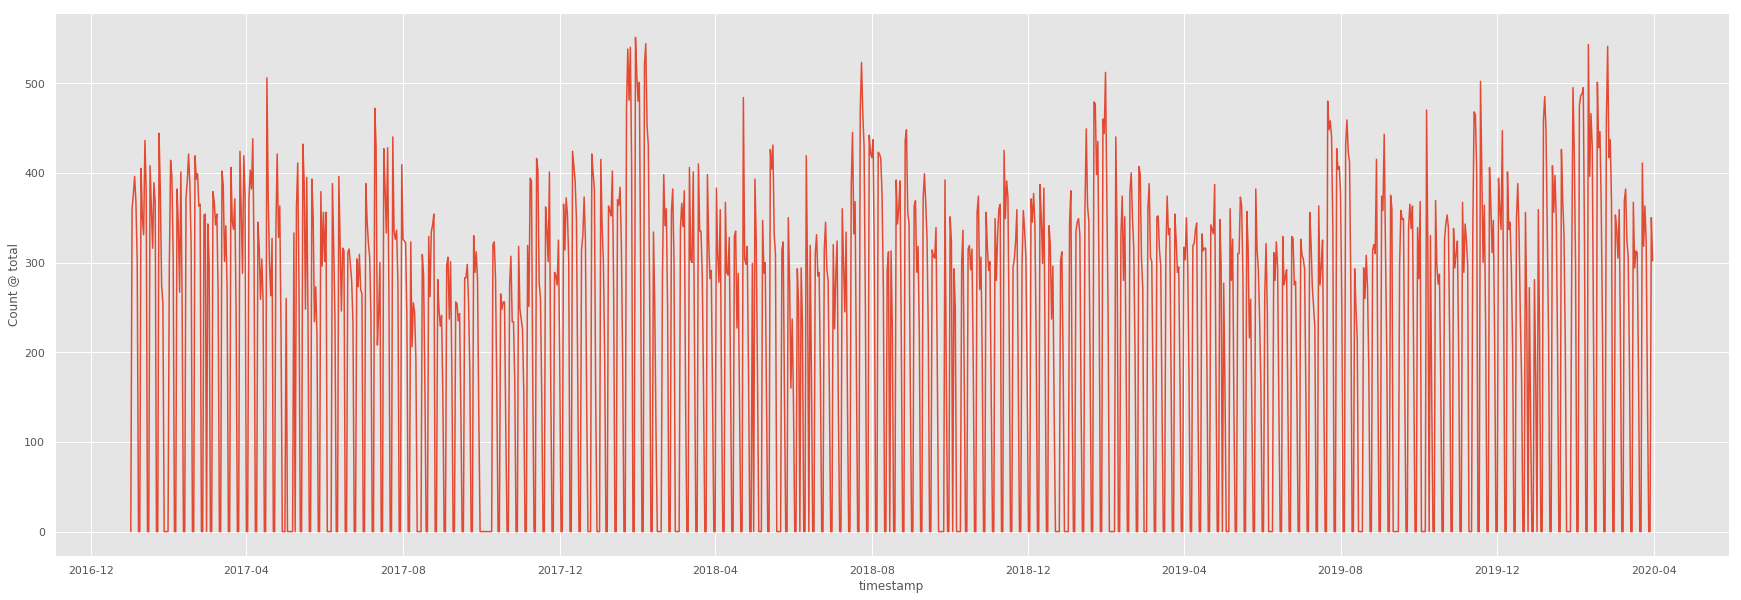

In [98]:
figure, ((ax1)) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(30,10)


sns.lineplot(x='timestamp', y='target_value', data=total_df, ax=ax1)

ax1.set(ylabel='Count @ total')
ax2.set(ylabel='Count @ breakfast')
ax3.set(ylabel='Count @ lunch')
ax4.set(ylabel='Count @ dinner')

- '17-09-30 ~ '17-10-09 추석 연휴
- 중식
    - 금요일에 식수인원이 적은 편으로 보임
    - 2월, 8월 식수인원이 많음

In [60]:
# #추석 연휴 쿼리
# total_df[(total_df['timestamp'] >= '2017-09-21') & (total_df['timestamp'] <= '2017-10-30')]

# 승지씨 여기 밑에부터 고쳐가며 진행하시면 될거같아요

# 상용로그 및 정규화 후, Q3(75%), Q1(25%) 값에 대한 날짜 리스트업

- 정규화: (요소값 - 최소값)/(최대값-최소값)
- 정확한 비교를 위해 주말 및 식당 미운영날의 데이터 삭제

In [99]:
# target_df 복사
lnch_df = total_df

In [100]:
# value 0 삭제
lnch_df = lnch_df[lnch_df['target_value'] != 0] 

In [101]:
# # 조식의 man, min
# bfst_min = bfst_df['target_value'].min()
# bfst_max = bfst_df['target_value'].max()


# print('중식의 min: ', bfst_min)
# print('중식의 max: ', bfst_max)
# print()



# 중식의 man, min
lnch_min = lnch_df['target_value'].min()
lnch_max = lnch_df['target_value'].max()
print('중식의 min: ', lnch_min)
print('중식의 max: ', lnch_max)
print()

# # 석식의 man, min
# dinr_min = dinr_df['target_value'].min()
# dinr_max = dinr_df['target_value'].max()
# print('석식의 min: ', dinr_min)
# print('석식의 max: ', dinr_max)
# print()



('\xec\xa4\x91\xec\x8b\x9d\xec\x9d\x98 min: ', 107)
('\xec\xa4\x91\xec\x8b\x9d\xec\x9d\x98 max: ', 551)
()


In [102]:
# 정규화
# (요소값 - 최소값)/(최대값-최소값)

# bfst_df['nor_target_value'] = (bfst_df['target_value'] - bfst_min)/(bfst_max - bfst_min)
lnch_df['nor_target_value'] = (lnch_df['target_value'] - lnch_min)/(lnch_max - lnch_min)
# dinr_df['nor_target_value'] = (dinr_df['target_value'] - dinr_min)/(dinr_max - dinr_min)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [103]:
# target_value를 상용log로 변환
# bfst_df['log_target_value'] = np.log10(bfst_df['target_value'])
lnch_df['log_target_value'] = np.log10(lnch_df['target_value'])
# dinr_df['log_target_value'] = np.log10(dinr_df['target_value'])

# -inf 제외 (<- x=0 일 때)
# bfst_df['log_target_value'] = bfst_df['log_target_value'].apply(lambda x: 0 if x < 0 else x)
lnch_df['log_target_value'] = lnch_df['log_target_value'].apply(lambda x: 0 if x < 0 else x)
# dinr_df['log_target_value'] = dinr_df['log_target_value'].apply(lambda x: 0 if x < 0 else x)


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [104]:
# targe_value 상용log를 정규화
# bfst_log_min = bfst_df['log_target_value'].min()
# bfst_log_max = bfst_df['log_target_value'].max()
# bfst_df['nor_log_target_value'] = (bfst_df['log_target_value'] - bfst_log_min)/(bfst_log_max - bfst_log_min)

lnch_log_min = lnch_df['log_target_value'].min()
lnch_log_max = lnch_df['log_target_value'].max()
lnch_df['nor_log_target_value'] = (lnch_df['log_target_value'] - lnch_log_min)/(lnch_log_max - lnch_log_min)

# dinr_log_min = bfst_df['log_target_value'].min()
# dinr_log_max = bfst_df['log_target_value'].max()
# dinr_df['nor_log_target_value'] = (dinr_df['log_target_value'] - dinr_log_min)/(dinr_log_max - dinr_log_min)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


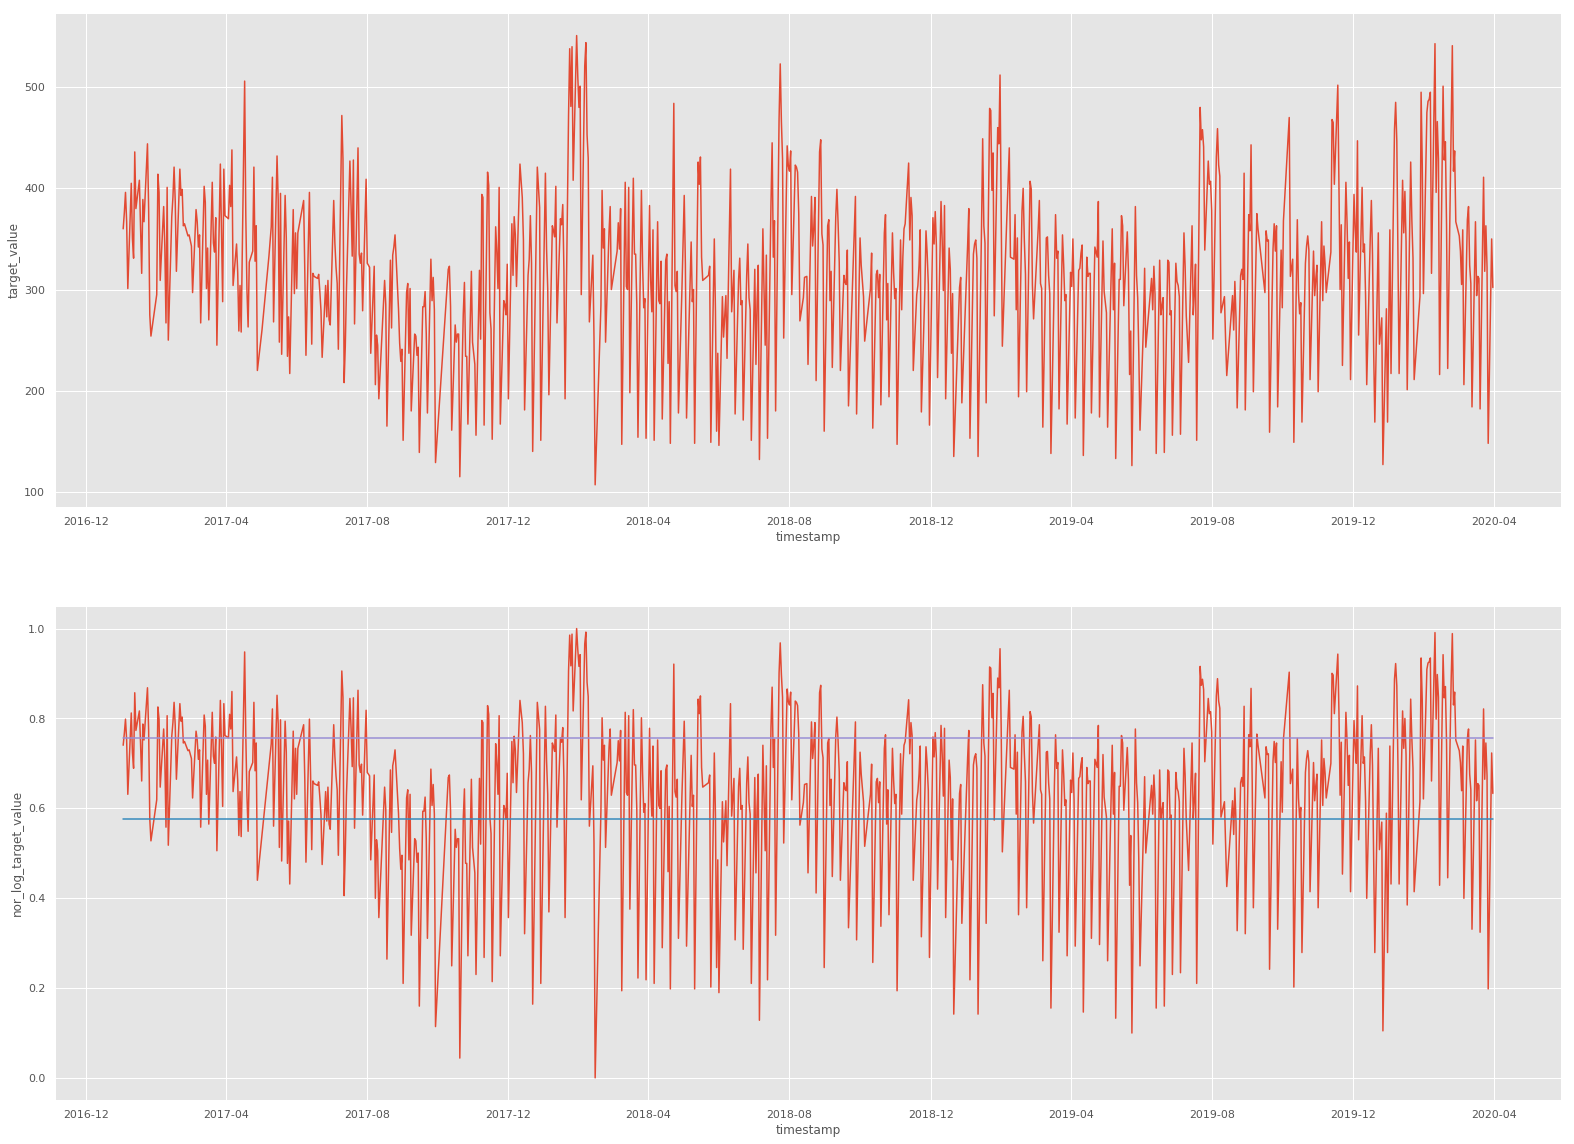

In [105]:
# 조식 선그래프에 그리기
fig, ((ax1), (ax2)) = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(27,20)

sns.lineplot(x='timestamp', y='target_value', data=lnch_df, ax=ax1)
sns.lineplot(x='timestamp', y='nor_log_target_value', data=lnch_df, ax=ax2)
sns.lineplot(x='timestamp', y=lnch_df['nor_log_target_value'].quantile(0.25), data=lnch_df, ax=ax2)
sns.lineplot(x='timestamp', y=lnch_df['nor_log_target_value'].quantile(0.75), data=lnch_df, ax=ax2)

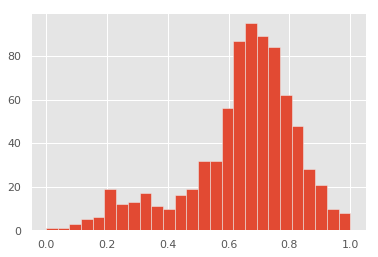

<Figure size 432x288 with 0 Axes>

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(0, 1)

# mu = lnch_df['nor_log_target_value'].values.mean()
# sigma = lnch_df['nor_log_target_value'].values.std()
# y = mlab.normpdf(10, mu, sigma)
# num_bins = 20
# ax.plot(y, norm.pdf(y),'g', lw=5, alpha=0.6, label='norm pdf')
# plt.show()

_ = plt.hist(lnch_df['nor_log_target_value'].values, bins='auto') 
plt.show()
plt.subplots_adjust(left=0.15)


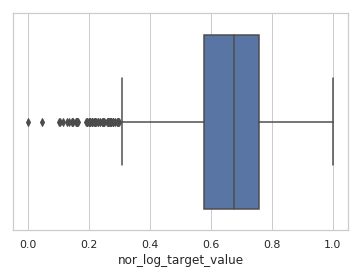

In [107]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(x=lnch_df['nor_log_target_value'])

In [108]:
lnch_df['nor_log_target_value'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0    0.000000
0.1    0.356742
0.2    0.527489
0.3    0.606257
0.4    0.641133
0.5    0.674123
0.6    0.707212
0.7    0.740296
0.8    0.781578
0.9    0.838118
1.0    1.000000
Name: nor_log_target_value, dtype: float64

In [121]:
lnch_df[lnch_df['yoil']!=4]['target_value'].describe()

count    627.000000
mean     345.637959
std       64.931333
min      107.000000
25%      301.000000
50%      338.000000
75%      383.500000
max      551.000000
Name: target_value, dtype: float64

In [223]:
lnch_df[lnch_df['yoil']==0]['target_value'].describe()

count    152.000000
mean     370.980263
std       60.152397
min      256.000000
25%      329.000000
50%      362.500000
75%      408.000000
max      551.000000
Name: target_value, dtype: float64

In [123]:
lnch_df['target_value'].describe()

count    785.000000
mean     319.357962
std       83.805886
min      107.000000
25%      275.000000
50%      323.000000
75%      370.000000
max      551.000000
Name: target_value, dtype: float64

In [162]:
friday=lnch_df[lnch_df['yoil']==4]
nonfri=lnch_df[lnch_df['yoil']!=4]

In [167]:
nonfri=nonfri[['timestamp', 'item_id','target_value']] #8일 fri 7일하면 되겟다

In [170]:
nonfri=nonfri.drop([1184,1185])

In [172]:
friday.to_csv('friday.csv',index=False)

In [110]:
import calendar
lnch_df['yoil']=lnch_df['timestamp'].apply(lambda x : calendar.weekday(x.year,x.month,x.day))

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


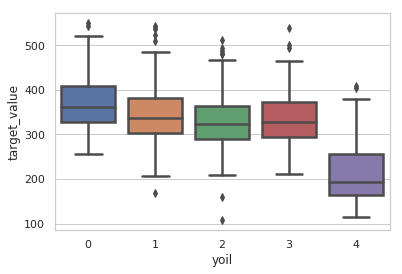

In [111]:
import seaborn as sns
sns.set(style="whitegrid")
# ax = sns.boxplot(x=lnch_df[lnch_df['yoil']==4]['target_value'])
ax = sns.boxplot(x="yoil", y='target_value',data=lnch_df, linewidth=2.5)

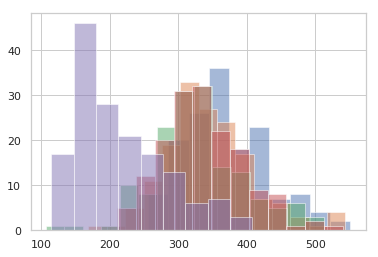

In [136]:
_ = plt.hist(lnch_df[lnch_df['yoil']==0]['target_value'].values, bins='auto',alpha=0.5) 
_ = plt.hist(lnch_df[lnch_df['yoil']==1]['target_value'].values, bins='auto',alpha=0.5)
_ = plt.hist(lnch_df[lnch_df['yoil']==2]['target_value'].values, bins='auto',alpha=0.5) 
_ = plt.hist(lnch_df[lnch_df['yoil']==3]['target_value'].values, bins='auto',alpha=0.5) 
_ = plt.hist(lnch_df[lnch_df['yoil']==4]['target_value'].values, bins='auto',alpha=0.5) 

In [139]:
import scipy as sp
from scipy.stats import chisquare
sp.stats.ks_2samp(lnch_df[lnch_df['yoil']==4]['target_value'].values, lnch_df[lnch_df['yoil']!=4]['target_value'].values) #콜모고로프-스미르노프 검정 3.579177550858381e-57<0.05 True H0기각, 다른 분포다

Ks_2sampResult(statistic=0.711293481113601, pvalue=3.579177550858381e-57)

In [142]:
lresult = stats.levene(lnch_df[lnch_df['yoil']==4]['target_value'].values, lnch_df[lnch_df['yoil']!=4]['target_value'].values)
print('LeveneResult(F) : %.3f \np-value : %.3f' % (lresult))

LeveneResult(F) : 0.629 
p-value : 0.428


In [144]:
#등분산이 아닌 독립표본 t-검정 실행 
result = stats.ttest_ind(lnch_df[lnch_df['yoil']==4]['target_value'].values, lnch_df[lnch_df['yoil']!=4]['target_value'].values, equal_var=True) 
print('t statistic : %.3f \np-value : %.3f' % (result))

t statistic : -22.408 
p-value : 0.000


In [146]:
from scipy.stats import ttest_1samp
tstat, pval = ttest_1samp(lnch_df[lnch_df['yoil']==4]['target_value'].values, 319.357962)
print(tstat, pval) #1.3957573561761742e-43<0.05 모집단 평균과 금요일 평균이 다르다

(-19.416122754059355, 1.3957573561761742e-43)


In [150]:
from scipy.stats import f_oneway
fstat, pval = f_oneway(lnch_df[lnch_df['yoil']==4]['target_value'].values, lnch_df[lnch_df['yoil']!=4]['target_value'].values, lnch_df['target_value'].values)
print(fstat, pval) # 셋다 다른 분포?

(190.22736769398995, 1.093635592085142e-74)


In [156]:
from scipy.stats import f_oneway
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
fstat, pval = f_oneway(lnch_df[lnch_df['yoil']==4]['target_value'].values, lnch_df[lnch_df['yoil']!=4]['target_value'].values, lnch_df['target_value'].values)
# np.concatenate를 통해 데이터를 합쳐 놓는다.
v = np.concatenate([lnch_df[lnch_df['yoil']==4]['target_value'].values, lnch_df[lnch_df['yoil']!=4]['target_value'].values, lnch_df['target_value'].values])
# 데이터 개수만큼 레이블을 준비한다.
labels = ['data1']*len(lnch_df[lnch_df['yoil']==4]['target_value'].values) + ['data2']*len(lnch_df[lnch_df['yoil']!=4]['target_value'].values) + ['data3']*len(lnch_df['target_value'].values)
# 사후 검정을 수행한다.
tukey_results = pairwise_tukeyhsd(v, labels, 0.05)
print(tukey_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
data1  data2  130.5683 114.8644 146.2723  True 
data1  data3  104.2883 88.9058  119.6709  True 
data2  data3   -26.28  -35.729  -16.831   True 
-----------------------------------------------


In [153]:
1.8754788025823855e-22<0.05

True

In [178]:
fri40=lnch_df[lnch_df['yoil']==4].sort_values('target_value',ascending=False).head(40)

In [211]:
fri40=fri40[(fri40.abnormal==0)&(fri40.rainfall==0)]

In [190]:
nfri40=lnch_df[lnch_df['yoil']!=4].sort_values('target_value',ascending=False).head(196)

In [192]:
nfri40=nfri40[(nfri40.abnormal==0)&(nfri40.rainfall==0)]

In [212]:
fri40=fri40[['timestamp', 'item_id','target_value','dayofweek_median', 'dayofweek_mean',
       'before_holiday', 'after_holiday', 'closed','rainfall', 'temperature', 'yoil']]

In [196]:
lunch=pd.read_csv('lunch_menu.csv',index_col=False)

In [203]:
lunch['timestamp']=pd.to_datetime(lunch['timestamp'])

In [221]:
tmt=pd.concat([fri40,nfri40])

In [222]:
pd.merge(tmt,lunch).menu.value_counts()

안동찜닭(닭고기:국내산)                                 2
가자미구이                                         2
삼겹살김치볶음(삼겹살:독일산)                              1
설렁탕*소면사리\n(우육:호주산)                            1
돈까스(돼지고기:국내산)                                 1
수제왕돈까스&하이라이스(돈육:국내산)                          1
대파육개장(쇠고기:호주산,\n사골엑기스:호주산)                    1
떡갈비스테이크&가니쉬\n(돈육,우육,계육:국산)                    1
짬뽕밥(오징어:칠래산)                                  1
돈등뼈해장국 (돈육: 국내산)                              1
돼지고기김치찜\n(돼지고기:국내산,배추:국내산,\n고추분:중국산)          1
돈육단호박찜 (돈육: 미국산)                              1
마파두부덮밥\n(돈육:국내산)                              1
뚝배기불고기\n(소고기:호주산)                             1
짜글이김치찌개(돼지고기:국내산\n배추:국내산,고추분:중국산)             1
육개장(우육:호주산,\n사골엑기스:뉴질랜드산)                     1
돈육유자청불고기(돈육:국내산)                              1
카레라이스(쇠고기:호주산)                                1
보쌈                                            1
육개장 (우육: 호주산)                                 1
육개장\n(우육:호주산)                           

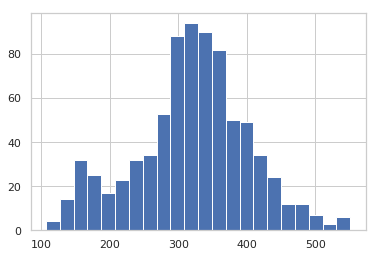

<Figure size 432x288 with 0 Axes>

In [115]:
_ = plt.hist(lnch_df['target_value'].values, bins='auto') 
plt.show()

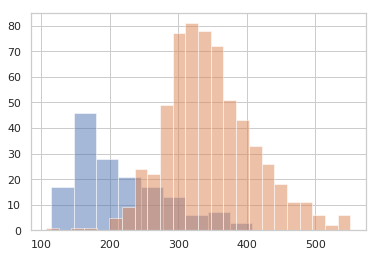

In [134]:
_ = plt.hist(lnch_df[lnch_df['yoil']==4]['target_value'].values, bins='auto',alpha=0.5) 
_ = plt.hist(lnch_df[lnch_df['yoil']!=4]['target_value'].values, bins='auto',alpha=0.5) 
plt.show()

---

### test

In [ ]:
fig, axes = plt(sub)

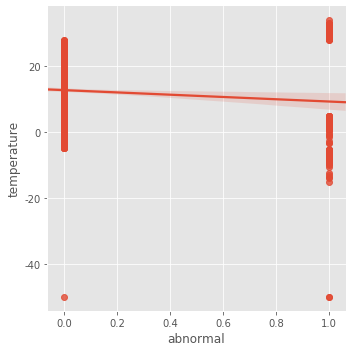

In [54]:
sns.lmplot(x='abnormal', y='temperature', data=abnor_df)

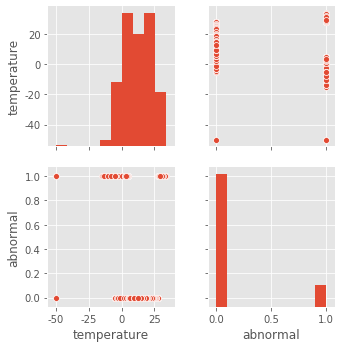

In [55]:
sns.pairplot(abnor_df)

In [ ]:
sns.pairplot(df)

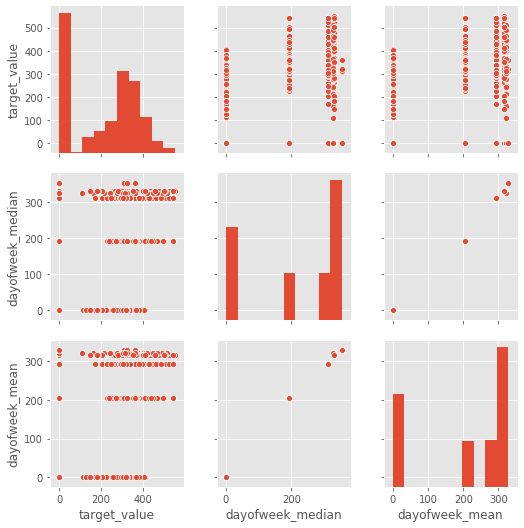

In [71]:
sns.pairplot(df[['target_value', 'dayofweek_median', 'dayofweek_mean']])

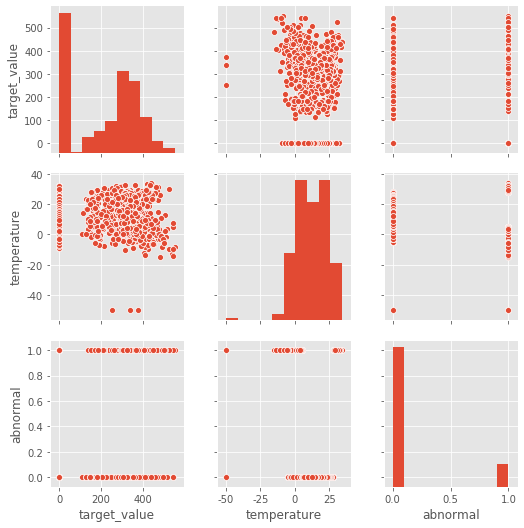

In [70]:
sns.pairplot(df[['target_value', 'temperature', 'abnormal']])

In [61]:
df[df['temperature'] <= -30]

,timestamp,item_id,rainfall,rain_prob,temperature,abnormal,holiday,before_holiday,after_holiday,closed,...,tue,wed,thur,fri,sat,sun,dayofweek_median,dayofweek_mean,target_value,month
943,2019-08-02,중식_소계,0.0,0.0,-50.0,0,0,1,0,0,...,0,0,0,1,0,0,0.0,0.000000,251,8
974,2019-09-02,중식_소계,0.0,0.3,-50.0,1,0,0,1,0,...,0,0,0,0,0,0,330.5,314.564706,374,9
1097,2020-01-03,중식_소계,0.0,0.0,-50.0,1,0,0,0,0,...,0,0,0,1,0,0,0.0,0.000000,338,1


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=target_df[target_df['target_value'] != 0], y='target_value', orient='v', ax=axes[0][0])
sns.boxplot(data=target_df[target_df['target_value'] != 0], y='target_value', x='month', orient='v', ax=axes[0][1])
sns.boxplot(data=target_df[target_df['target_value'] != 0], y='target_value', x='day', orient='v', ax=axes[1][0])
sns.boxplot(data=target_df[target_df['target_value'] != 0], y='target_value', x='meal', orient='v', ax=axes[1][1])

axes[0][0].set(ylabel='Count', title='label')
axes[0][1].set(ylabel='month', title='label per month')
axes[1][0].set(ylabel='day', title='label per day')
axes[1][1].set(ylabel='meal', title='label per meal')

In [ ]:
sns.lmplot(x="size", y="price", data=df, line_kws={'color':"red"})

In [ ]:
## 기본틀
df.apply(lambda x: func(x['col1'],x['col2']),axis=1)

def custom(type1 , hp) :
    if 'Dragon' in type1 :
        return hp + 100
    elif 'Normal' in type1 :
        return hp/2
    else :
        return hp
    
df["New_hp"] = df.apply(lambda x : custom(x["type1"], x["hp"]) , axis = 1 )

df[["type1", "hp","New_hp"]].groupby( "type1" ).first().head()